1. **Temporal cross-validation setup** 
   - Rolling window validation
2. **Model fine-tuning using time series-aware grid search**
3. **Extraction and storage of feature importance for each fold**
4. **Analysis of most frequently selected hyperparameters and features**
5. **Retraining with the dominant configuration**
6. **Final performance evaluation**

In [2]:
target = 'cogs_eur'

# this list was provided by Adam (current features in the causal model)
columns_used_to_train = [
'aov_eur',
'available_stock_value_after_discount_complete_eur',
'avg_temp',
'cpc',
'cr_tracked_%',
'email_recipients',
'email_visits',
'internalWeeks_until_SeasonalSaleStart',
'internal_Week_of_FW_Season',
'internal_Week_of_SS_Season',
'is_Peak_Driving_Public_Holiday_week',
'is_Sun_to_Mon_Shift_week',
'is_black_week_event',
'is_email_campaign_type_deal',
'is_email_campaign_type_liveshop',
'is_email_campaign_type_newsletter',
'is_percentage_on_top',
'is_percentage_on_top_applicable',
'is_season_sale_event',
'is_temp_drop_flag',
'number_days_after_last_event',
'number_days_till_next_event',
'number_orders',
'number_visits',
'sku_with_discount_%',
'stock_discount_rate_total_%',
'target_cpr']

In [3]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    explained_variance_score
)

# --- 1. Load & prep --------------------------------------------------------
df = pd.read_csv("COGS_Data_for_taining_26072025.csv", parse_dates=['Unnamed: 0'])
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.sort_values('date').set_index('date')

X = df[columns_used_to_train].values
y = df[target].values
dates = df.index

In [4]:
# --- 2. Carve off final hold-out (last 8 weeks) ----------------------------
H = 8    # hold-out horizon
train_cut = len(df) - H
X_hist, y_hist = X[:train_cut], y[:train_cut]
dates_hist = dates[:train_cut]

X_final, y_final = X[train_cut:], y[train_cut:]
dates_final = dates[train_cut:]

# --- 3. Rolling-origin CV on history ----------------------------------------
W = 52   # training window
h = 8    # test window
scores = []
best_params_list = []
feature_importances_list = []

# we can only start a fold where (start + W + h) ≤ len(history)
n_folds = (len(X_hist) - W - h) + 1

param_grid = {
    'min_child_weight': [0.3, 0.4, 0.5],
    'n_estimators':       [100, 200, 300],
    'learning_rate':      [0.01, 0.05, 0.1],    # if using XGBoost; RF ignores this
    'max_depth':          [5, 7, 9],
}

for i in tqdm(range(n_folds)):
    train_start = i
    train_end   = i + W          # exclusive
    test_end    = train_end + h  # exclusive

    X_tr = X_hist[train_start:train_end]
    y_tr = y_hist[train_start:train_end]
    X_va = X_hist[train_end:test_end]
    y_va = y_hist[train_end:test_end]

    # train
    current_model = xg.XGBRegressor(random_state=42, seed=123, n_jobs=-1)
    # Grid search
    grid_search = GridSearchCV(current_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_tr, y_tr)
    # Get best model
    best_model = grid_search.best_estimator_
    # Get best parameters
    best_params = grid_search.best_params_
    # Fit best model
    best_model.fit(X_tr, y_tr)
    # Get feature importances
    feature_importances = best_model.feature_importances_
    importances = pd.Series(
        best_model.feature_importances_,
        index=columns_used_to_train
    )
    feature_importances_list.append(importances)
    # Get best parameters
    best_params_list.append(best_params)
    

    # predict & score
    y_pred = best_model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_va, y_pred)
    r2 = r2_score(y_va, y_pred)

    scores.append({'fold': i+1, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2})

    print(f"Fold {i+1:02d}: Train weeks {train_start+1}-{train_end}, "
          f"Test weeks {train_end+1}-{test_end} → MSE {mse:.2f}, MAE {mae:.2f}")

cv_df = pd.DataFrame(scores)
print("\nCV mean MSE:", cv_df['mse'].mean(), "MAE:", cv_df['mae'].mean())
feat_importance_df = pd.DataFrame(feature_importances_list)
best_params_df = pd.DataFrame(best_params_list)

  1%|          | 1/106 [00:12<21:29, 12.28s/it]

Fold 01: Train weeks 1-52, Test weeks 53-60 → MSE 40474391620.65, MAE 178983.37


  2%|▏         | 2/106 [00:16<13:22,  7.72s/it]

Fold 02: Train weeks 2-53, Test weeks 54-61 → MSE 30802325957.29, MAE 127117.93


  3%|▎         | 3/106 [00:21<11:02,  6.43s/it]

Fold 03: Train weeks 3-54, Test weeks 55-62 → MSE 8124045664.68, MAE 72827.88


  4%|▍         | 4/106 [00:26<09:56,  5.85s/it]

Fold 04: Train weeks 4-55, Test weeks 56-63 → MSE 5983184995.76, MAE 63199.72


  5%|▍         | 5/106 [00:33<10:23,  6.18s/it]

Fold 05: Train weeks 5-56, Test weeks 57-64 → MSE 4659220069.85, MAE 61902.93


  6%|▌         | 6/106 [00:38<09:57,  5.97s/it]

Fold 06: Train weeks 6-57, Test weeks 58-65 → MSE 12390767770.79, MAE 100918.96


  7%|▋         | 7/106 [00:43<08:55,  5.41s/it]

Fold 07: Train weeks 7-58, Test weeks 59-66 → MSE 13249094143.43, MAE 98990.01


  8%|▊         | 8/106 [00:49<09:02,  5.54s/it]

Fold 08: Train weeks 8-59, Test weeks 60-67 → MSE 7189572652.46, MAE 62656.64


  8%|▊         | 9/106 [00:56<10:00,  6.19s/it]

Fold 09: Train weeks 9-60, Test weeks 61-68 → MSE 16812944845.84, MAE 85691.45


  9%|▉         | 10/106 [01:02<09:31,  5.96s/it]

Fold 10: Train weeks 10-61, Test weeks 62-69 → MSE 17448574768.05, MAE 97702.54


 10%|█         | 11/106 [01:07<09:20,  5.90s/it]

Fold 11: Train weeks 11-62, Test weeks 63-70 → MSE 20668630203.19, MAE 99360.39


 11%|█▏        | 12/106 [01:13<08:53,  5.67s/it]

Fold 12: Train weeks 12-63, Test weeks 64-71 → MSE 22124286835.27, MAE 100826.18


 12%|█▏        | 13/106 [01:17<08:15,  5.33s/it]

Fold 13: Train weeks 13-64, Test weeks 65-72 → MSE 24377810067.42, MAE 105766.71


 13%|█▎        | 14/106 [01:23<08:36,  5.61s/it]

Fold 14: Train weeks 14-65, Test weeks 66-73 → MSE 29535163313.81, MAE 129607.22


 14%|█▍        | 15/106 [01:29<08:30,  5.61s/it]

Fold 15: Train weeks 15-66, Test weeks 67-74 → MSE 40543184146.76, MAE 157530.99


 15%|█▌        | 16/106 [01:34<08:03,  5.37s/it]

Fold 16: Train weeks 16-67, Test weeks 68-75 → MSE 41318380803.59, MAE 160105.22


 16%|█▌        | 17/106 [01:38<07:31,  5.07s/it]

Fold 17: Train weeks 17-68, Test weeks 69-76 → MSE 49947850609.87, MAE 168912.11


 17%|█▋        | 18/106 [01:43<07:10,  4.89s/it]

Fold 18: Train weeks 18-69, Test weeks 70-77 → MSE 71021531821.63, MAE 201969.78


 18%|█▊        | 19/106 [01:47<06:50,  4.72s/it]

Fold 19: Train weeks 19-70, Test weeks 71-78 → MSE 92221497489.90, MAE 258363.87


 19%|█▉        | 20/106 [01:52<06:47,  4.73s/it]

Fold 20: Train weeks 20-71, Test weeks 72-79 → MSE 95940470954.97, MAE 274952.95


 20%|█▉        | 21/106 [01:56<06:31,  4.60s/it]

Fold 21: Train weeks 21-72, Test weeks 73-80 → MSE 151829801875.30, MAE 330372.33


 21%|██        | 22/106 [02:00<06:23,  4.57s/it]

Fold 22: Train weeks 22-73, Test weeks 74-81 → MSE 69096606565.91, MAE 215522.80


 22%|██▏       | 23/106 [02:05<06:27,  4.67s/it]

Fold 23: Train weeks 23-74, Test weeks 75-82 → MSE 77313448959.59, MAE 251050.20


 23%|██▎       | 24/106 [02:10<06:22,  4.67s/it]

Fold 24: Train weeks 24-75, Test weeks 76-83 → MSE 80971251752.77, MAE 256548.30


 24%|██▎       | 25/106 [02:14<06:00,  4.45s/it]

Fold 25: Train weeks 25-76, Test weeks 77-84 → MSE 60411383177.23, MAE 210335.02


 25%|██▍       | 26/106 [02:18<05:47,  4.35s/it]

Fold 26: Train weeks 26-77, Test weeks 78-85 → MSE 30923147437.50, MAE 144033.96


 25%|██▌       | 27/106 [02:22<05:39,  4.29s/it]

Fold 27: Train weeks 27-78, Test weeks 79-86 → MSE 25523298611.84, MAE 131235.09


 26%|██▋       | 28/106 [02:27<05:39,  4.35s/it]

Fold 28: Train weeks 28-79, Test weeks 80-87 → MSE 34454179303.39, MAE 161977.59


 27%|██▋       | 29/106 [02:31<05:37,  4.39s/it]

Fold 29: Train weeks 29-80, Test weeks 81-88 → MSE 27667857528.63, MAE 131450.51


 28%|██▊       | 30/106 [02:36<05:43,  4.53s/it]

Fold 30: Train weeks 30-81, Test weeks 82-89 → MSE 47873276668.12, MAE 162242.65


 29%|██▉       | 31/106 [02:40<05:31,  4.42s/it]

Fold 31: Train weeks 31-82, Test weeks 83-90 → MSE 1363868480398.57, MAE 600295.35


 30%|███       | 32/106 [02:44<05:20,  4.33s/it]

Fold 32: Train weeks 32-83, Test weeks 84-91 → MSE 2004766939159.77, MAE 680189.71


 31%|███       | 33/106 [02:49<05:13,  4.30s/it]

Fold 33: Train weeks 33-84, Test weeks 85-92 → MSE 1392259535234.43, MAE 649632.97


 32%|███▏      | 34/106 [02:53<05:05,  4.24s/it]

Fold 34: Train weeks 34-85, Test weeks 86-93 → MSE 2453502702013.30, MAE 962683.99


 33%|███▎      | 35/106 [02:57<04:57,  4.19s/it]

Fold 35: Train weeks 35-86, Test weeks 87-94 → MSE 2495759833942.00, MAE 979247.83


 34%|███▍      | 36/106 [03:01<05:01,  4.31s/it]

Fold 36: Train weeks 36-87, Test weeks 88-95 → MSE 2476815273302.54, MAE 946129.69


 35%|███▍      | 37/106 [03:06<05:09,  4.49s/it]

Fold 37: Train weeks 37-88, Test weeks 89-96 → MSE 2605132420104.56, MAE 1040517.70


 36%|███▌      | 38/106 [03:10<04:58,  4.38s/it]

Fold 38: Train weeks 38-89, Test weeks 90-97 → MSE 2279892119534.58, MAE 945161.82


 37%|███▋      | 39/106 [03:15<04:55,  4.41s/it]

Fold 39: Train weeks 39-90, Test weeks 91-98 → MSE 5182325688154.05, MAE 1309515.27


 38%|███▊      | 40/106 [03:20<04:56,  4.49s/it]

Fold 40: Train weeks 40-91, Test weeks 92-99 → MSE 5165542333162.68, MAE 1388480.21


 39%|███▊      | 41/106 [03:23<04:36,  4.25s/it]

Fold 41: Train weeks 41-92, Test weeks 93-100 → MSE 5499261689125.48, MAE 1411544.58


 40%|███▉      | 42/106 [03:27<04:29,  4.22s/it]

Fold 42: Train weeks 42-93, Test weeks 94-101 → MSE 122094121902.24, MAE 313866.76


 41%|████      | 43/106 [03:32<04:31,  4.30s/it]

Fold 43: Train weeks 43-94, Test weeks 95-102 → MSE 132227103001.54, MAE 297428.82


 42%|████▏     | 44/106 [03:36<04:28,  4.33s/it]

Fold 44: Train weeks 44-95, Test weeks 96-103 → MSE 136254357747.89, MAE 325002.66


 42%|████▏     | 45/106 [03:40<04:22,  4.30s/it]

Fold 45: Train weeks 45-96, Test weeks 97-104 → MSE 128658891338.81, MAE 332720.92


 43%|████▎     | 46/106 [03:45<04:14,  4.24s/it]

Fold 46: Train weeks 46-97, Test weeks 98-105 → MSE 137621147899.74, MAE 345204.73


 44%|████▍     | 47/106 [03:49<04:16,  4.35s/it]

Fold 47: Train weeks 47-98, Test weeks 99-106 → MSE 83329456032.91, MAE 276661.58


 45%|████▌     | 48/106 [03:54<04:15,  4.40s/it]

Fold 48: Train weeks 48-99, Test weeks 100-107 → MSE 31163745412.68, MAE 161892.17


 46%|████▌     | 49/106 [03:58<04:03,  4.26s/it]

Fold 49: Train weeks 49-100, Test weeks 101-108 → MSE 69290376673.35, MAE 186764.89


 47%|████▋     | 50/106 [04:01<03:49,  4.10s/it]

Fold 50: Train weeks 50-101, Test weeks 102-109 → MSE 70070880961.53, MAE 207529.11


 48%|████▊     | 51/106 [04:06<03:52,  4.23s/it]

Fold 51: Train weeks 51-102, Test weeks 103-110 → MSE 68442559903.45, MAE 185160.03


 49%|████▉     | 52/106 [04:10<03:40,  4.08s/it]

Fold 52: Train weeks 52-103, Test weeks 104-111 → MSE 69609786254.03, MAE 217086.86


 50%|█████     | 53/106 [04:13<03:30,  3.97s/it]

Fold 53: Train weeks 53-104, Test weeks 105-112 → MSE 26513863096.46, MAE 137153.62


 51%|█████     | 54/106 [04:18<03:33,  4.10s/it]

Fold 54: Train weeks 54-105, Test weeks 106-113 → MSE 21412169111.19, MAE 120170.93


 52%|█████▏    | 55/106 [04:22<03:29,  4.11s/it]

Fold 55: Train weeks 55-106, Test weeks 107-114 → MSE 13358146947.77, MAE 105022.33


 53%|█████▎    | 56/106 [04:26<03:22,  4.06s/it]

Fold 56: Train weeks 56-107, Test weeks 108-115 → MSE 32486282483.75, MAE 161652.44


 54%|█████▍    | 57/106 [04:30<03:18,  4.04s/it]

Fold 57: Train weeks 57-108, Test weeks 109-116 → MSE 25193071099.77, MAE 132758.12


 55%|█████▍    | 58/106 [04:34<03:20,  4.18s/it]

Fold 58: Train weeks 58-109, Test weeks 110-117 → MSE 26100181743.79, MAE 134728.59


 56%|█████▌    | 59/106 [04:39<03:20,  4.27s/it]

Fold 59: Train weeks 59-110, Test weeks 111-118 → MSE 7605630348.41, MAE 60926.14


 57%|█████▋    | 60/106 [04:43<03:21,  4.38s/it]

Fold 60: Train weeks 60-111, Test weeks 112-119 → MSE 1808990499.43, MAE 38013.06


 58%|█████▊    | 61/106 [04:47<03:09,  4.21s/it]

Fold 61: Train weeks 61-112, Test weeks 113-120 → MSE 9568968517.12, MAE 64276.69


 58%|█████▊    | 62/106 [04:51<03:05,  4.21s/it]

Fold 62: Train weeks 62-113, Test weeks 114-121 → MSE 9467347164.43, MAE 65539.32


 59%|█████▉    | 63/106 [04:56<03:07,  4.36s/it]

Fold 63: Train weeks 63-114, Test weeks 115-122 → MSE 33427678326.72, MAE 128906.28


 60%|██████    | 64/106 [05:01<03:10,  4.53s/it]

Fold 64: Train weeks 64-115, Test weeks 116-123 → MSE 37507380550.29, MAE 147274.25


 61%|██████▏   | 65/106 [05:06<03:12,  4.70s/it]

Fold 65: Train weeks 65-116, Test weeks 117-124 → MSE 55120801736.37, MAE 192689.88


 62%|██████▏   | 66/106 [05:11<03:07,  4.70s/it]

Fold 66: Train weeks 66-117, Test weeks 118-125 → MSE 38592874692.10, MAE 169268.77


 63%|██████▎   | 67/106 [05:15<02:56,  4.52s/it]

Fold 67: Train weeks 67-118, Test weeks 119-126 → MSE 43258610267.92, MAE 192057.47


 64%|██████▍   | 68/106 [05:19<02:45,  4.35s/it]

Fold 68: Train weeks 68-119, Test weeks 120-127 → MSE 48276674379.55, MAE 196547.76


 65%|██████▌   | 69/106 [05:23<02:35,  4.21s/it]

Fold 69: Train weeks 69-120, Test weeks 121-128 → MSE 1672078693033.65, MAE 622531.43


 66%|██████▌   | 70/106 [05:27<02:31,  4.20s/it]

Fold 70: Train weeks 70-121, Test weeks 122-129 → MSE 2139388195071.24, MAE 679298.62


 67%|██████▋   | 71/106 [05:31<02:27,  4.22s/it]

Fold 71: Train weeks 71-122, Test weeks 123-130 → MSE 490166405624.65, MAE 407772.99


 68%|██████▊   | 72/106 [05:35<02:23,  4.21s/it]

Fold 72: Train weeks 72-123, Test weeks 124-131 → MSE 518599843384.17, MAE 433879.41


 69%|██████▉   | 73/106 [05:40<02:17,  4.16s/it]

Fold 73: Train weeks 73-124, Test weeks 125-132 → MSE 720882622345.42, MAE 542226.46


 70%|██████▉   | 74/106 [05:44<02:16,  4.27s/it]

Fold 74: Train weeks 74-125, Test weeks 126-133 → MSE 1621850282681.54, MAE 736434.76


 71%|███████   | 75/106 [05:48<02:13,  4.31s/it]

Fold 75: Train weeks 75-126, Test weeks 127-134 → MSE 1644950228276.72, MAE 731397.00


 72%|███████▏  | 76/106 [05:53<02:12,  4.40s/it]

Fold 76: Train weeks 76-127, Test weeks 128-135 → MSE 3678026711836.43, MAE 1103117.06


 73%|███████▎  | 77/106 [05:58<02:09,  4.45s/it]

Fold 77: Train weeks 77-128, Test weeks 129-136 → MSE 146114866367.88, MAE 271964.84


 74%|███████▎  | 78/106 [06:03<02:08,  4.58s/it]

Fold 78: Train weeks 78-129, Test weeks 130-137 → MSE 125222470968.51, MAE 192475.62


 75%|███████▍  | 79/106 [06:07<02:01,  4.52s/it]

Fold 79: Train weeks 79-130, Test weeks 131-138 → MSE 144002538500.20, MAE 224113.67


 75%|███████▌  | 80/106 [06:11<01:54,  4.42s/it]

Fold 80: Train weeks 80-131, Test weeks 132-139 → MSE 158846000265.42, MAE 223761.29


 76%|███████▋  | 81/106 [06:15<01:45,  4.23s/it]

Fold 81: Train weeks 81-132, Test weeks 133-140 → MSE 97221333196.82, MAE 235182.18


 77%|███████▋  | 82/106 [06:19<01:41,  4.24s/it]

Fold 82: Train weeks 82-133, Test weeks 134-141 → MSE 100803295837.30, MAE 240929.33


 78%|███████▊  | 83/106 [06:23<01:38,  4.28s/it]

Fold 83: Train weeks 83-134, Test weeks 135-142 → MSE 272570747913.65, MAE 367107.01


 79%|███████▉  | 84/106 [06:28<01:35,  4.35s/it]

Fold 84: Train weeks 84-135, Test weeks 136-143 → MSE 1731306210291.35, MAE 773682.55


 80%|████████  | 85/106 [06:32<01:30,  4.30s/it]

Fold 85: Train weeks 85-136, Test weeks 137-144 → MSE 1748791951253.52, MAE 777347.08


 81%|████████  | 86/106 [06:36<01:24,  4.24s/it]

Fold 86: Train weeks 86-137, Test weeks 138-145 → MSE 1773427351205.28, MAE 834881.36


 82%|████████▏ | 87/106 [06:41<01:20,  4.25s/it]

Fold 87: Train weeks 87-138, Test weeks 139-146 → MSE 1396915535083.64, MAE 678543.96


 83%|████████▎ | 88/106 [06:45<01:15,  4.22s/it]

Fold 88: Train weeks 88-139, Test weeks 140-147 → MSE 1384659852537.44, MAE 662893.96


 84%|████████▍ | 89/106 [06:49<01:12,  4.27s/it]

Fold 89: Train weeks 89-140, Test weeks 141-148 → MSE 1135494404693.05, MAE 629218.35


 85%|████████▍ | 90/106 [06:54<01:08,  4.31s/it]

Fold 90: Train weeks 90-141, Test weeks 142-149 → MSE 3385907036578.43, MAE 1203028.63


 86%|████████▌ | 91/106 [06:58<01:04,  4.33s/it]

Fold 91: Train weeks 91-142, Test weeks 143-150 → MSE 1116239648964.77, MAE 551037.85


 87%|████████▋ | 92/106 [07:02<01:01,  4.41s/it]

Fold 92: Train weeks 92-143, Test weeks 144-151 → MSE 61769612711.73, MAE 230581.20


 88%|████████▊ | 93/106 [07:07<00:56,  4.36s/it]

Fold 93: Train weeks 93-144, Test weeks 145-152 → MSE 61148209756.33, MAE 223023.82


 89%|████████▊ | 94/106 [07:11<00:53,  4.46s/it]

Fold 94: Train weeks 94-145, Test weeks 146-153 → MSE 102715983366.71, MAE 285528.67


 90%|████████▉ | 95/106 [07:16<00:50,  4.56s/it]

Fold 95: Train weeks 95-146, Test weeks 147-154 → MSE 149358568551.08, MAE 334290.15


 91%|█████████ | 96/106 [07:21<00:44,  4.49s/it]

Fold 96: Train weeks 96-147, Test weeks 148-155 → MSE 73874810764.79, MAE 247287.98


 92%|█████████▏| 97/106 [07:25<00:40,  4.47s/it]

Fold 97: Train weeks 97-148, Test weeks 149-156 → MSE 151175988674.80, MAE 352280.30


 92%|█████████▏| 98/106 [07:29<00:34,  4.36s/it]

Fold 98: Train weeks 98-149, Test weeks 150-157 → MSE 101462330846.63, MAE 286711.66


 93%|█████████▎| 99/106 [07:34<00:30,  4.42s/it]

Fold 99: Train weeks 99-150, Test weeks 151-158 → MSE 173570987854.61, MAE 356181.22


 94%|█████████▍| 100/106 [07:37<00:25,  4.24s/it]

Fold 100: Train weeks 100-151, Test weeks 152-159 → MSE 123046758200.78, MAE 287269.83


 95%|█████████▌| 101/106 [07:41<00:20,  4.16s/it]

Fold 101: Train weeks 101-152, Test weeks 153-160 → MSE 131001134847.83, MAE 321694.59


 96%|█████████▌| 102/106 [07:46<00:16,  4.20s/it]

Fold 102: Train weeks 102-153, Test weeks 154-161 → MSE 33596660963.15, MAE 137883.90


 97%|█████████▋| 103/106 [07:50<00:12,  4.08s/it]

Fold 103: Train weeks 103-154, Test weeks 155-162 → MSE 30832299802.07, MAE 141713.83


 98%|█████████▊| 104/106 [07:54<00:08,  4.07s/it]

Fold 104: Train weeks 104-155, Test weeks 156-163 → MSE 64230547386.66, MAE 159229.63


 99%|█████████▉| 105/106 [07:57<00:03,  3.95s/it]

Fold 105: Train weeks 105-156, Test weeks 157-164 → MSE 63848730335.83, MAE 169558.63


100%|██████████| 106/106 [08:01<00:00,  4.55s/it]

Fold 106: Train weeks 106-157, Test weeks 158-165 → MSE 78854153406.46, MAE 195213.85

CV mean MSE: 606155078266.238 MAE: 351538.99282429245


In [17]:
cv_df['mape'].mean()

np.float64(0.0788739811330915)

In [18]:
# saving the files
cv_df.to_csv('./cogs/files/cross_validation_results.csv')
feat_importance_df.to_csv('./cogs/files/feature_importance_results.csv')
best_params_df.to_csv('./cogs/files/best_params_results.csv')

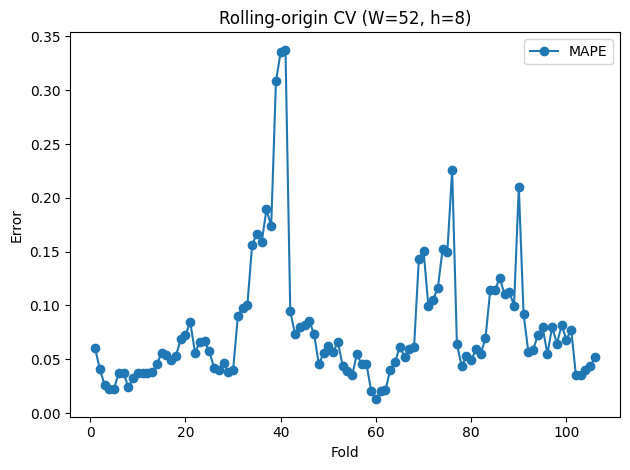

In [19]:
# --- 4. Plot CV metrics ----------------------------------------------------
plt.figure()
plt.plot(cv_df['fold'], cv_df['mape'], marker='o', label='MAPE')
# plt.plot(cv_df['fold'], cv_df['mae'], marker='s', label='MAE')
plt.xlabel("Fold")
plt.ylabel("Error")
plt.title(f"Rolling-origin CV (W={W}, h={H})")
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

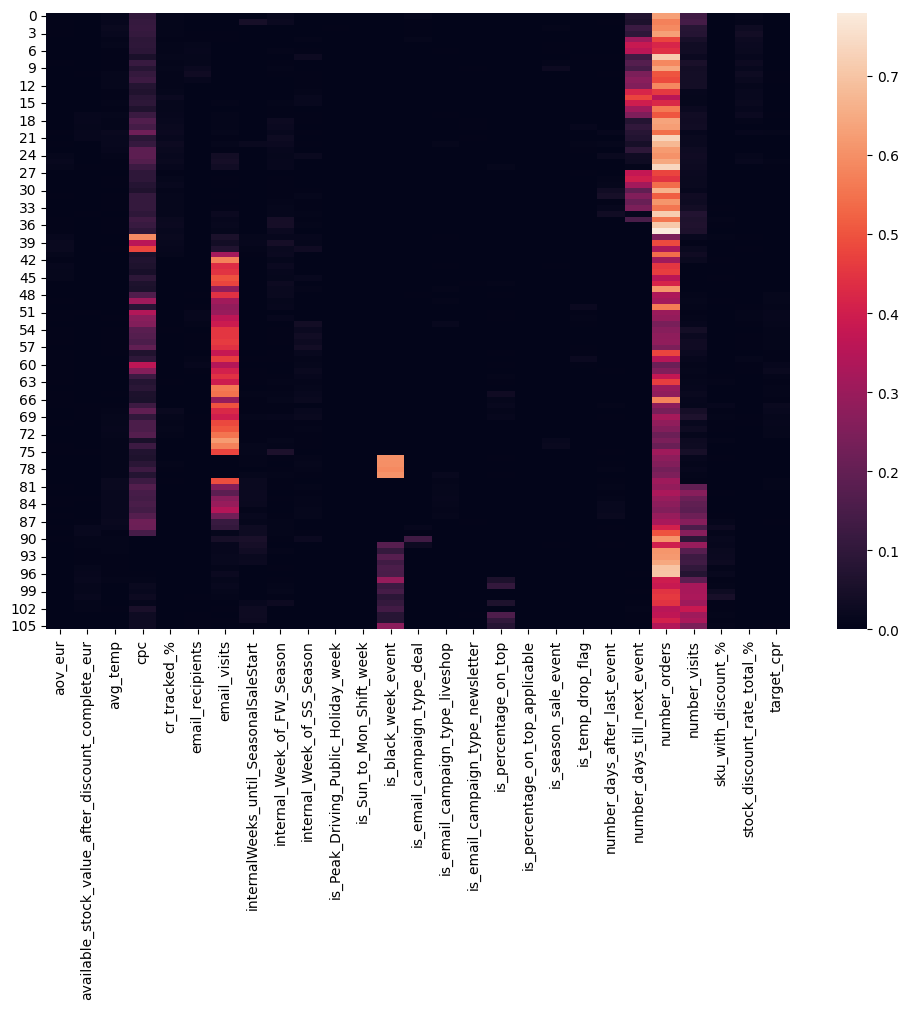

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(feat_importance_df)

## Base on Feature Importance Filtering Features to Use

In [21]:
feat_imp_mean_series = feat_importance_df.mean() * 100
feat_imp_mean_series.sort_values(ascending=False)

number_orders                                        44.424305
email_visits                                         17.218782
cpc                                                  12.000779
number_visits                                         7.512202
number_days_till_next_event                           6.801900
is_black_week_event                                   4.348468
internal_Week_of_FW_Season                            0.943033
internalWeeks_until_SeasonalSaleStart                 0.702073
internal_Week_of_SS_Season                            0.697647
is_percentage_on_top                                  0.696653
avg_temp                                              0.663319
cr_tracked_%                                          0.627506
stock_discount_rate_total_%                           0.504599
sku_with_discount_%                                   0.432560
aov_eur                                               0.371431
available_stock_value_after_discount_complete_eur     0

In [22]:
SELECTED_FEATURES_TO_KEEP = list(feat_imp_mean_series[feat_imp_mean_series > 0.3].index)

In [23]:
best_params_df

,learning_rate,max_depth,min_child_weight,n_estimators
0,0.10,7,0.3,300
1,0.10,5,0.3,300
2,0.05,5,0.3,300
3,0.05,5,0.3,300
4,0.05,5,0.3,300
...,...,...,...,...
101,0.10,5,0.3,300
102,0.10,5,0.3,100
103,0.05,5,0.3,200
104,0.10,5,0.3,100


In [24]:
best_params_df['learning_rate'].value_counts() / best_params_df.shape[0] * 100

learning_rate
0.10    45.283019
0.05    28.301887
0.01    26.415094
Name: count, dtype: float64

In [25]:
best_params_df['max_depth'].value_counts()/best_params_df.shape[0] * 100

max_depth
5    60.377358
9    23.584906
7    16.037736
Name: count, dtype: float64

In [26]:
best_params_df['min_child_weight'].value_counts()/best_params_df.shape[0] * 100

min_child_weight
0.3    100.0
Name: count, dtype: float64

In [27]:
best_params_df['n_estimators'].value_counts()/best_params_df.shape[0] * 100

n_estimators
300    66.037736
200    18.867925
100    15.094340
Name: count, dtype: float64

In [28]:
best_params_df.mean()

learning_rate         0.062075
max_depth             6.264151
min_child_weight      0.300000
n_estimators        250.943396
dtype: float64

# Final Training with
    - Limited features
    - Tune hyperparameters

In [29]:
# --- 1. Load & prep --------------------------------------------------------
df = pd.read_csv("COGS_Data_for_taining_26072025.csv", parse_dates=['Unnamed: 0'])
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.sort_values('date').set_index('date')

X = df[SELECTED_FEATURES_TO_KEEP].values
y = df[target].values
dates = df.index

In [30]:
# --- 2. Carve off final hold-out (last 8 weeks) ----------------------------
H = 8    # hold-out horizon
train_cut = len(df) - H
X_hist, y_hist = X[:train_cut], y[:train_cut]
dates_hist = dates[:train_cut]

X_final, y_final = X[train_cut:], y[train_cut:]
dates_final = dates[train_cut:]

# --- 3. Rolling-origin CV on history ----------------------------------------
W = 52   # training window
h = 8    # test window
scores = []

# we can only start a fold where (start + W + h) ≤ len(history)
n_folds = (len(X_hist) - W - h) + 1

for i in range(n_folds):
    train_start = i
    train_end   = i + W          # exclusive
    test_end    = train_end + h  # exclusive

    X_tr = X_hist[train_start:train_end]
    y_tr = y_hist[train_start:train_end]
    X_va = X_hist[train_end:test_end]
    y_va = y_hist[train_end:test_end]

    # train
    final_model = xg.XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.10, 
                        min_child_weight = 0.3, random_state=42, n_jobs=-1)
    final_model.fit(X_tr, y_tr)

    # predict & score
    y_pred = final_model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_va, y_pred)
    r2 = r2_score(y_va, y_pred)

    scores.append({'fold': i+1, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2})

    print(f"Fold {i+1:02d}: Train weeks {train_start+1}-{train_end}, "
          f"Test weeks {train_end+1}-{test_end} → MAPE {mape:.2f}, MAE {mae:.2f}")

cv_df = pd.DataFrame(scores)
print("\nCV mean MAPE:", cv_df['mape'].mean(), "MAE:", cv_df['mae'].mean())

Fold 01: Train weeks 1-52, Test weeks 53-60 → MAPE 0.05, MAE 164213.79
Fold 02: Train weeks 2-53, Test weeks 54-61 → MAPE 0.04, MAE 127743.93
Fold 03: Train weeks 3-54, Test weeks 55-62 → MAPE 0.03, MAE 71271.57
Fold 04: Train weeks 4-55, Test weeks 56-63 → MAPE 0.02, MAE 61067.09
Fold 05: Train weeks 5-56, Test weeks 57-64 → MAPE 0.03, MAE 74191.15
Fold 06: Train weeks 6-57, Test weeks 58-65 → MAPE 0.03, MAE 93055.18
Fold 07: Train weeks 7-58, Test weeks 59-66 → MAPE 0.03, MAE 84775.92
Fold 08: Train weeks 8-59, Test weeks 60-67 → MAPE 0.03, MAE 71879.97
Fold 09: Train weeks 9-60, Test weeks 61-68 → MAPE 0.03, MAE 88573.37
Fold 10: Train weeks 10-61, Test weeks 62-69 → MAPE 0.04, MAE 94929.99
Fold 11: Train weeks 11-62, Test weeks 63-70 → MAPE 0.04, MAE 98270.46
Fold 12: Train weeks 12-63, Test weeks 64-71 → MAPE 0.04, MAE 96245.34
Fold 13: Train weeks 13-64, Test weeks 65-72 → MAPE 0.04, MAE 104168.58
Fold 14: Train weeks 14-65, Test weeks 66-73 → MAPE 0.04, MAE 122101.37
Fold 15: Tr

In [31]:
cv_df['mape'].mean()

np.float64(0.0762661270334337)

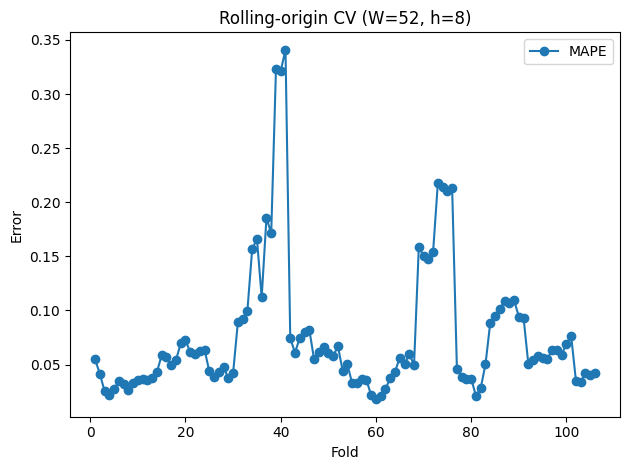

In [32]:
# --- 4. Plot CV metrics ----------------------------------------------------
plt.figure()
plt.plot(cv_df['fold'], cv_df['mape'], marker='o', label='MAPE')
# plt.plot(cv_df['fold'], cv_df['mae'], marker='s', label='MAE')
plt.xlabel("Fold")
plt.ylabel("Error")
plt.title(f"Rolling-origin CV (W={W}, h={H})")
plt.legend()
plt.tight_layout()
plt.show()


Final 8-week hold-out → MAPE: 0.03904080643155283 MSE: 25324698392.83797 MAE: 136412.8187500001


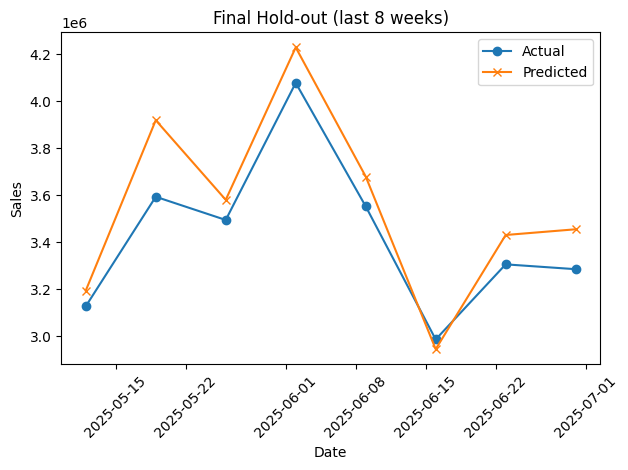

In [33]:
# --- 5. Final hold-out evaluation on last 52 weeks data -----------------------------------------
y_final_pred = final_model.predict(X_final)
print("\nFinal 8-week hold-out →",
      "MAPE:", mean_absolute_percentage_error(y_final, y_final_pred),
      "MSE:", mean_squared_error(y_final, y_final_pred),
      "MAE:", mean_absolute_error(y_final, y_final_pred))

plt.figure()
plt.plot(dates_final, y_final,  marker='o', label='Actual')
plt.plot(dates_final, y_final_pred, marker='x', label='Predicted')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Final Hold-out (last 8 weeks)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
import os
import joblib

# save model
joblib.dump(final_model, './cogs/model/cogs_model.joblib')

['./cogs/model/cogs_model.joblib']

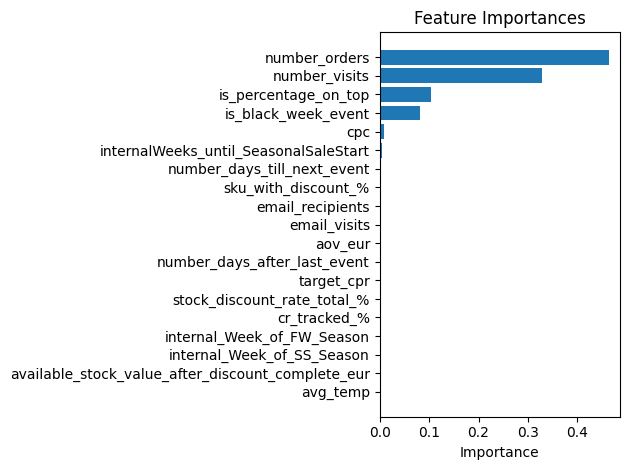

In [37]:
# --- 6. Feature importances -----------------------------------------------
importances = pd.Series(final_model.feature_importances_, index=SELECTED_FEATURES_TO_KEEP)
importances = importances.sort_values(ascending=False)

plt.figure()
plt.barh(importances.index, importances.values)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()